In [1]:
import argparse, pickle, os, re, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Simulate running model as with 00train_model.py
os.chdir(Path.home() / 'Code/Python/tensormorph_redup')
sys.path.append('../phon')
sys.path.append('./tensormorph')
from tensormorph import *

# Convert tensor to numpy with rounding
#def t2np(x, digits=2):
#    y = x.data.numpy()
#    y = np.round(y, digits)
#    return y

print('imported')

imported


In [19]:
# # # # # PLOTS # # # # #
# Plotting config
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.sans-serif'] = ['Noto Sans', 'Droid Sans', 'DejaVu Sans Mono']
#'Arial Unicode MS', 'Noto Sans', 'Lucida Grande', 'Verdana'
plt.rcParams['font.serif'] = ['DejaVu Sans', 'Noto Serif', 'Droid Sans', ]
#'Arial Unicode MS', 'DejaVu Sans', 'Times New Romain', 'Noto Serif'

# Plot tensor-product representation
def plot_tpr(M, M_str=None, nrole=None):
    features = config.ftrs
    if nrole is None:
        nrole = config.nrole
    fig = plt.figure(figsize=(10,8), dpi=300)
    
    # TPR matrix
    M = M.detach().numpy()[:,0:nrole]
    plt.pcolormesh(M, vmin=-1.0, vmax=1.0,
                   edgecolors='black', shading='flat', linewidth=0.5)
    ax1 = plt.gca() # get plot axes, creating if necessary
    
    # Features on y-axis
    ax1.invert_yaxis()
    ax1.set_yticks([i+0.5 for i in range(len(features))])
    ax1.set_yticklabels(features, fontsize=16)
    ax1.set_ylabel('features', fontsize=18)

    # Positions on bottom x-axis
    ax1.set_xticks([i+0.5 for i in range(nrole)])
    ax1.set_xticklabels([i for i in range(nrole)], fontsize=16)
    ax1.set_xlabel('positions', fontsize=18)
    #ax1.tick_params(top=False)
    
    # Decoded string on upper x-axis
    if M_str is not None:
        M_str = M_str.split()
        # Pad on right
        if len(M_str) < nrole:
            M_str += [config.epsilon] * (nrole - len(M_str)) # xxx config.epsilon
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks([i+0.5 for i in range(nrole)])
        ax2.set_xticklabels(M_str, fontsize=16)

    ax1.tick_params(bottom=False, top=False, left=False, right=False)
    ax2.tick_params(bottom=False, top=False, left=False, right=False)
    plt.tight_layout()


# Plot matrix
def imshow(M, xlab=[], ylab=[], title='', show_legend=True):
    fig, ax = plt.subplots(1,1)
    im = ax.imshow(M.detach().numpy())
    _ = ax.set_xticks(range(len(xlab)))
    _ = ax.set_xticklabels(xlab)
    _ = ax.set_yticks(range(len(ylab)))
    _ = ax.set_yticklabels(ylab)
    _ = ax.set_title(title)
    if show_legend:
        _ = fig.colorbar(im, ax=ax)


# Top-k elements of probability distribution
def topk(prob, k=5, keys=None):
    prob = prob.t() # rearrange to [nrole x nsym]
    print(prob.shape)
    for i in range(prob.shape[0]):
        prob_i = prob[i]
        val, indx = torch.sort(prob_i, descending=True)
        out = ' + '.join([f'{keys[indx[j]]}({val[j]:0.2f})' for j in range(k)])
        print(out)
        #val = torch.cumsum(val, 0)
        #print(val)
        #out = []
        #for j in range(5):
        #    out.append(keys[indx[j]])
        #    if val[j] > theta:
        #        break
        #print(i, out)
    return None

In [3]:
%%capture
sim = ['catalan_adjectives', 'english_verb_reg1', 'korean_verbs'][1]
print(sim)

# Initialize environment
fargs = Path.home() / f'Desktop/tmorph_output/english_verb_reg1/{sim}_config.pkl'
args = pickle.load(open(fargs, 'rb'))
config = tensormorph.init(args)

In [4]:
# Load model
fmodel = Path.home() / f'Desktop/tmorph_output/english_verb_reg1/{sim}_model.pt'
grammar = config.grammar
grammar.load_state_dict(torch.load(fmodel))
form_embedder = config.form_embedder
decoder = config.decoder
#decoder.add_noise = False
phonology = grammar.cogrammar.phonology
print(config.syms)

['ϵ', '⋊', '⋉', 'ɑ', 'a', 'æ', 'ʌ', 'ɔ', 'o', 'ə', 'e', 'ɛ', 'u', 'ʊ', 'i', 'ɪ', 'ŋ', 'n', 'm', 'l', 'k', 'g', 'ʒ', 'z', 'v', 't', 'ʃ', 's', 'p', 'f', 'd', 'b', 'θ', 'ð', 'dʒ', 'tʃ', 'w', 'j', 'ɹ', 'h']


In [5]:
tensormorph.evaluate('test')

test accuracy: 0.9992401215805471 (2/2632 errors)
         stem     output   morphosyn  stem_len  output_len   idx split  \
369   s m u ð  s m u ð z  v;3;sg;prs         4           5  5371  test   
1447    b e ð    b e ð z  v;3;sg;prs         3           4   235  test   

             pred  score  
369   s m u ð z z      0  
1447    b e ð z z      0  


In [6]:
split = 'test'
dat_embed = getattr(config, f'data_{split}')
batch = data_util.morph_batcher(dat_embed)
print([x for x in batch])
print(batch['stem'].form.shape)
print(batch['morphosyn'][0].shape)

['idx', 'stem_str', 'output_str', 'morphosyn_str', 'stem', 'output', 'morphosyn', 'pred', 'max_len']
torch.Size([2632, 26, 22])
torch.Size([2632, 3])


Mslot2dim_attn
           slot0
number  0.938966
person  0.815340
pos     0.932610
tense   0.710025
['none', 'after ⋊', 'before ⋉', 'before first C', 'before first V', 'before first X', 'before last C', 'before last V', 'before last X', 'after first C', 'after first V', 'after first X', 'after last C', 'after last V', 'after last X', 'after first σ', 'before last σ', 'circumfix1']
tensor([ 0.2638, -0.1287,  0.4183, -0.1407, -0.1714, -0.1302,  1.1774,  0.3874,
         0.2105, -0.1986, -0.1989, -0.1713,  0.3510,  0.6505,  6.5809,  4.0563,
        -0.1223,  4.0049], grad_fn=<SelectBackward>)
tensor([0.0015, 0.0010, 0.0018, 0.0010, 0.0010, 0.0010, 0.0038, 0.0017, 0.0014,
        0.0010, 0.0010, 0.0010, 0.0017, 0.0022, 0.8457, 0.0677, 0.0010, 0.0643],
       grad_fn=<SelectBackward>)
torch.Size([22, 40])
s(-109.02) + z(-127.58) + ⋉(-135.36) + ə(-136.00) + ϵ(-147.36)
ϵ(-0.94) + ⋉(-12.66) + ⋊(-12.89) + m(-93.05) + b(-95.77)
ϵ(-61.86) + ⋉(-70.79) + ⋊(-82.79) + g(-85.31) + d(-93.55)
ϵ(-0.01) +

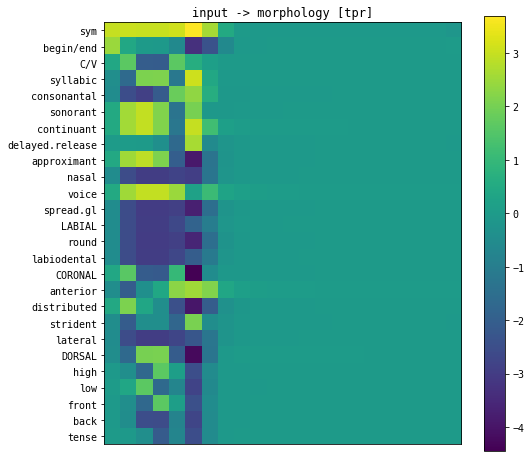

/Library/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8906 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8905 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8906 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8905 missing from current font.
  font.set_text(s, 0, flags=flags)


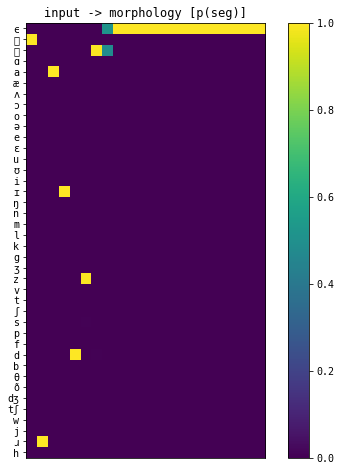

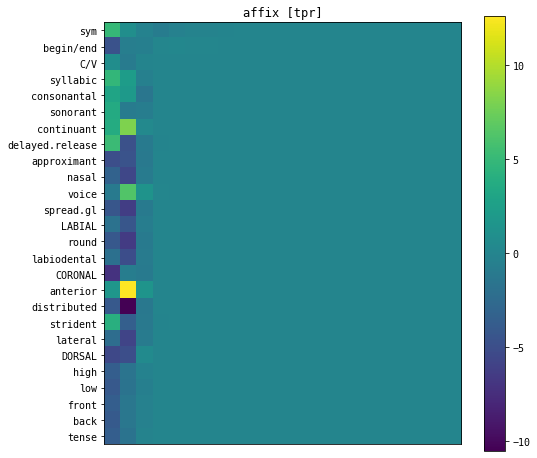

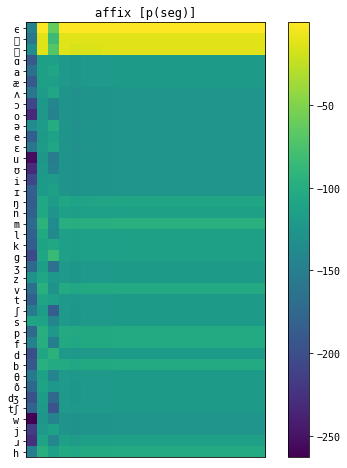

In [7]:
# Run model on input
config.recorder = recorder.Recorder()
grammar.cogrammar.phonology = [None, phonology][0] # deactivate / activate phonology
#print('morphology_hwy', torch.sigmoid(grammar.cogrammar.morphology_hwy))

if sim == 'catalan_adjectives':
    cntxt = [torch.tensor([0.0, 0.0, 1.0]).unsqueeze(0), torch.tensor([0.0, 1.0]).unsqueeze(0)]
    #inpt_ = '⋊ s ˈa n ə ⋉'
    inpt_ = '⋊ f r ˈɛ ð ə ⋉'
    #inpt_ = '⋊ k u ˈa k ə ɾ ə ⋉'
    #inpt_ = '⋊ p u r p ɾ ˈa ð ə ⋉'
    #inpt_ = '⋊ m u ɾ ˈo z ə ⋉'
elif sim == 'english_verb_reg1':
    cntxt = [torch.tensor([0.0, 0.0, 1.0]), # 'number': ['Ø', 'pl', 'sg']
             torch.tensor([0.0, 1.0]), # 'person': ['Ø', '3']
             torch.tensor([0.0, 1.0]), # 'pos': ['Ø', 'v']
             torch.tensor([0.0, 1.0, 0.0])] # 'tense': ['Ø', 'prs', 'pst']
    cntxt = [cntxt[i].unsqueeze(0) for i in range(len(cntxt))]
    #inpt_ = '⋊ ɹ a ɪ t ⋉'
    inpt_ = '⋊ ɹ a ɪ d ⋉'
    #inpt_ = '⋊ ɹ a ɪ z ⋉'
    #inpt_ = '⋊ p l ʌ n dʒ ⋉'
elif sim == 'korean_verbs':
    pass
    
inpt = form_embedder.string2tpr(inpt_, delim=False).unsqueeze(0)
batch = {'stem':morph.Morph(inpt), 'morphosyn':cntxt, 'max_len':15}
outpt = grammar(batch)
outpt_logp = decoder(outpt.form) # xxx normalize logprobs?
outpt_p = torch.softmax(outpt_logp, dim=1)

#print('pivot_stem', grammar.cogrammar.stem.pivot[0])

pivots = grammar.cogrammar.cogrammar.affixer.pivoter.pivots
W_pivot = grammar.cogrammar.cogrammar.affixer.W
A_pivot = grammar.cogrammar.cogrammar.affixer.A
print(pivots)
print(W_pivot[0])
print(A_pivot[0])

#outpt_ = form_embedder.tpr2string(outpt.form)
stem = grammar.cogrammar.stem
stem_ = grammar.cogrammar.stem._str()[0]
affix = grammar.cogrammar.affix
affix_ = grammar.cogrammar.affix._str(trim=False)[0]
affix_logp = decoder(affix.form * affix.copy.unsqueeze(1)) # xxx normalize logprobs?
affix_p = torch.softmax(affix_logp, dim=1)

print(topk(affix_logp[0], k=5, keys=config.syms))

print(topk(outpt_logp[0], k=5, keys=config.syms))

outpt_ = outpt._str()[0]
print(stem_); print(form_embedder.tpr2string(stem.form)[0])
print(stem.pivot[0])
print(affix_); print(form_embedder.tpr2string(affix.form)[0])
print('output', outpt_)

imshow(outpt.form[0], xlab=[], ylab=config.ftrs, title='input -> morphology [tpr]')

imshow(outpt_p[0], xlab=[], ylab=config.syms, title='input -> morphology [p(seg)]')

#imshow(torch.tanh(affix.form * affix.copy.unsqueeze(1))[0], xlab=[], ylab=config.ftrs, title='affix [tpr]')
imshow(affix.form[0], xlab=[], ylab=config.ftrs, title='affix [tpr]')

imshow(affix_logp[0], xlab=[], ylab=config.syms, title='affix [p(seg)]')

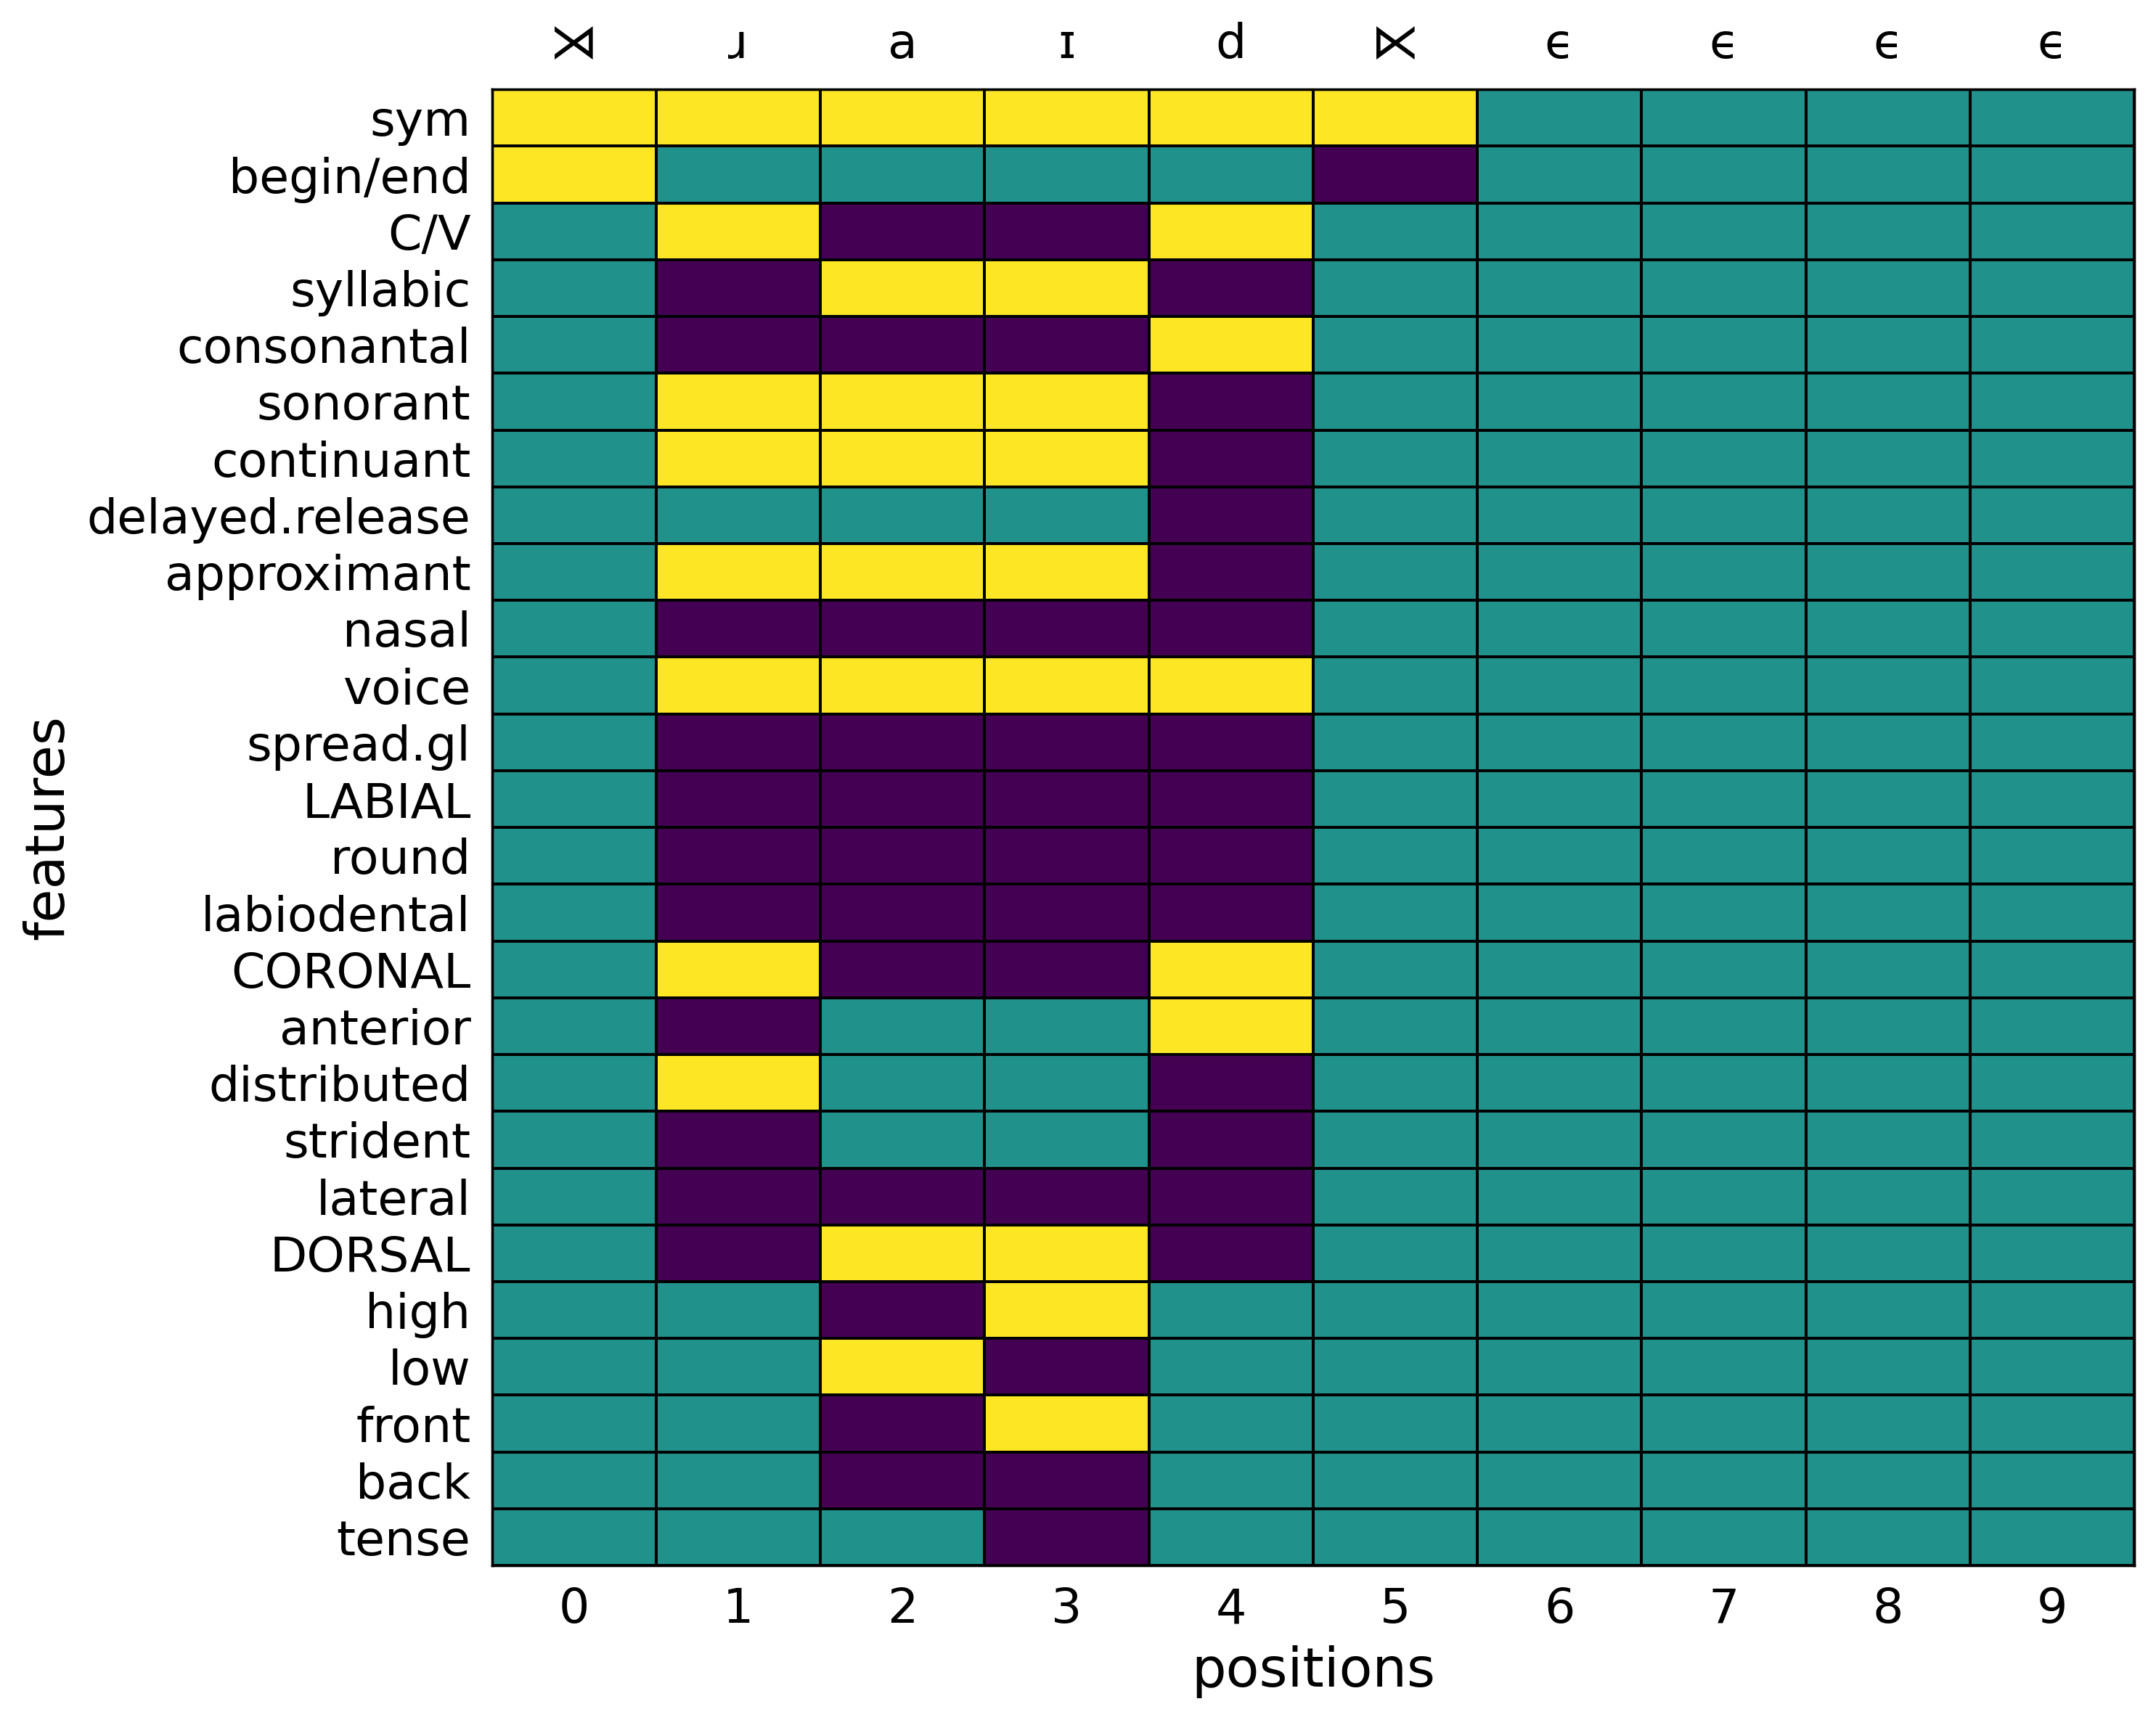

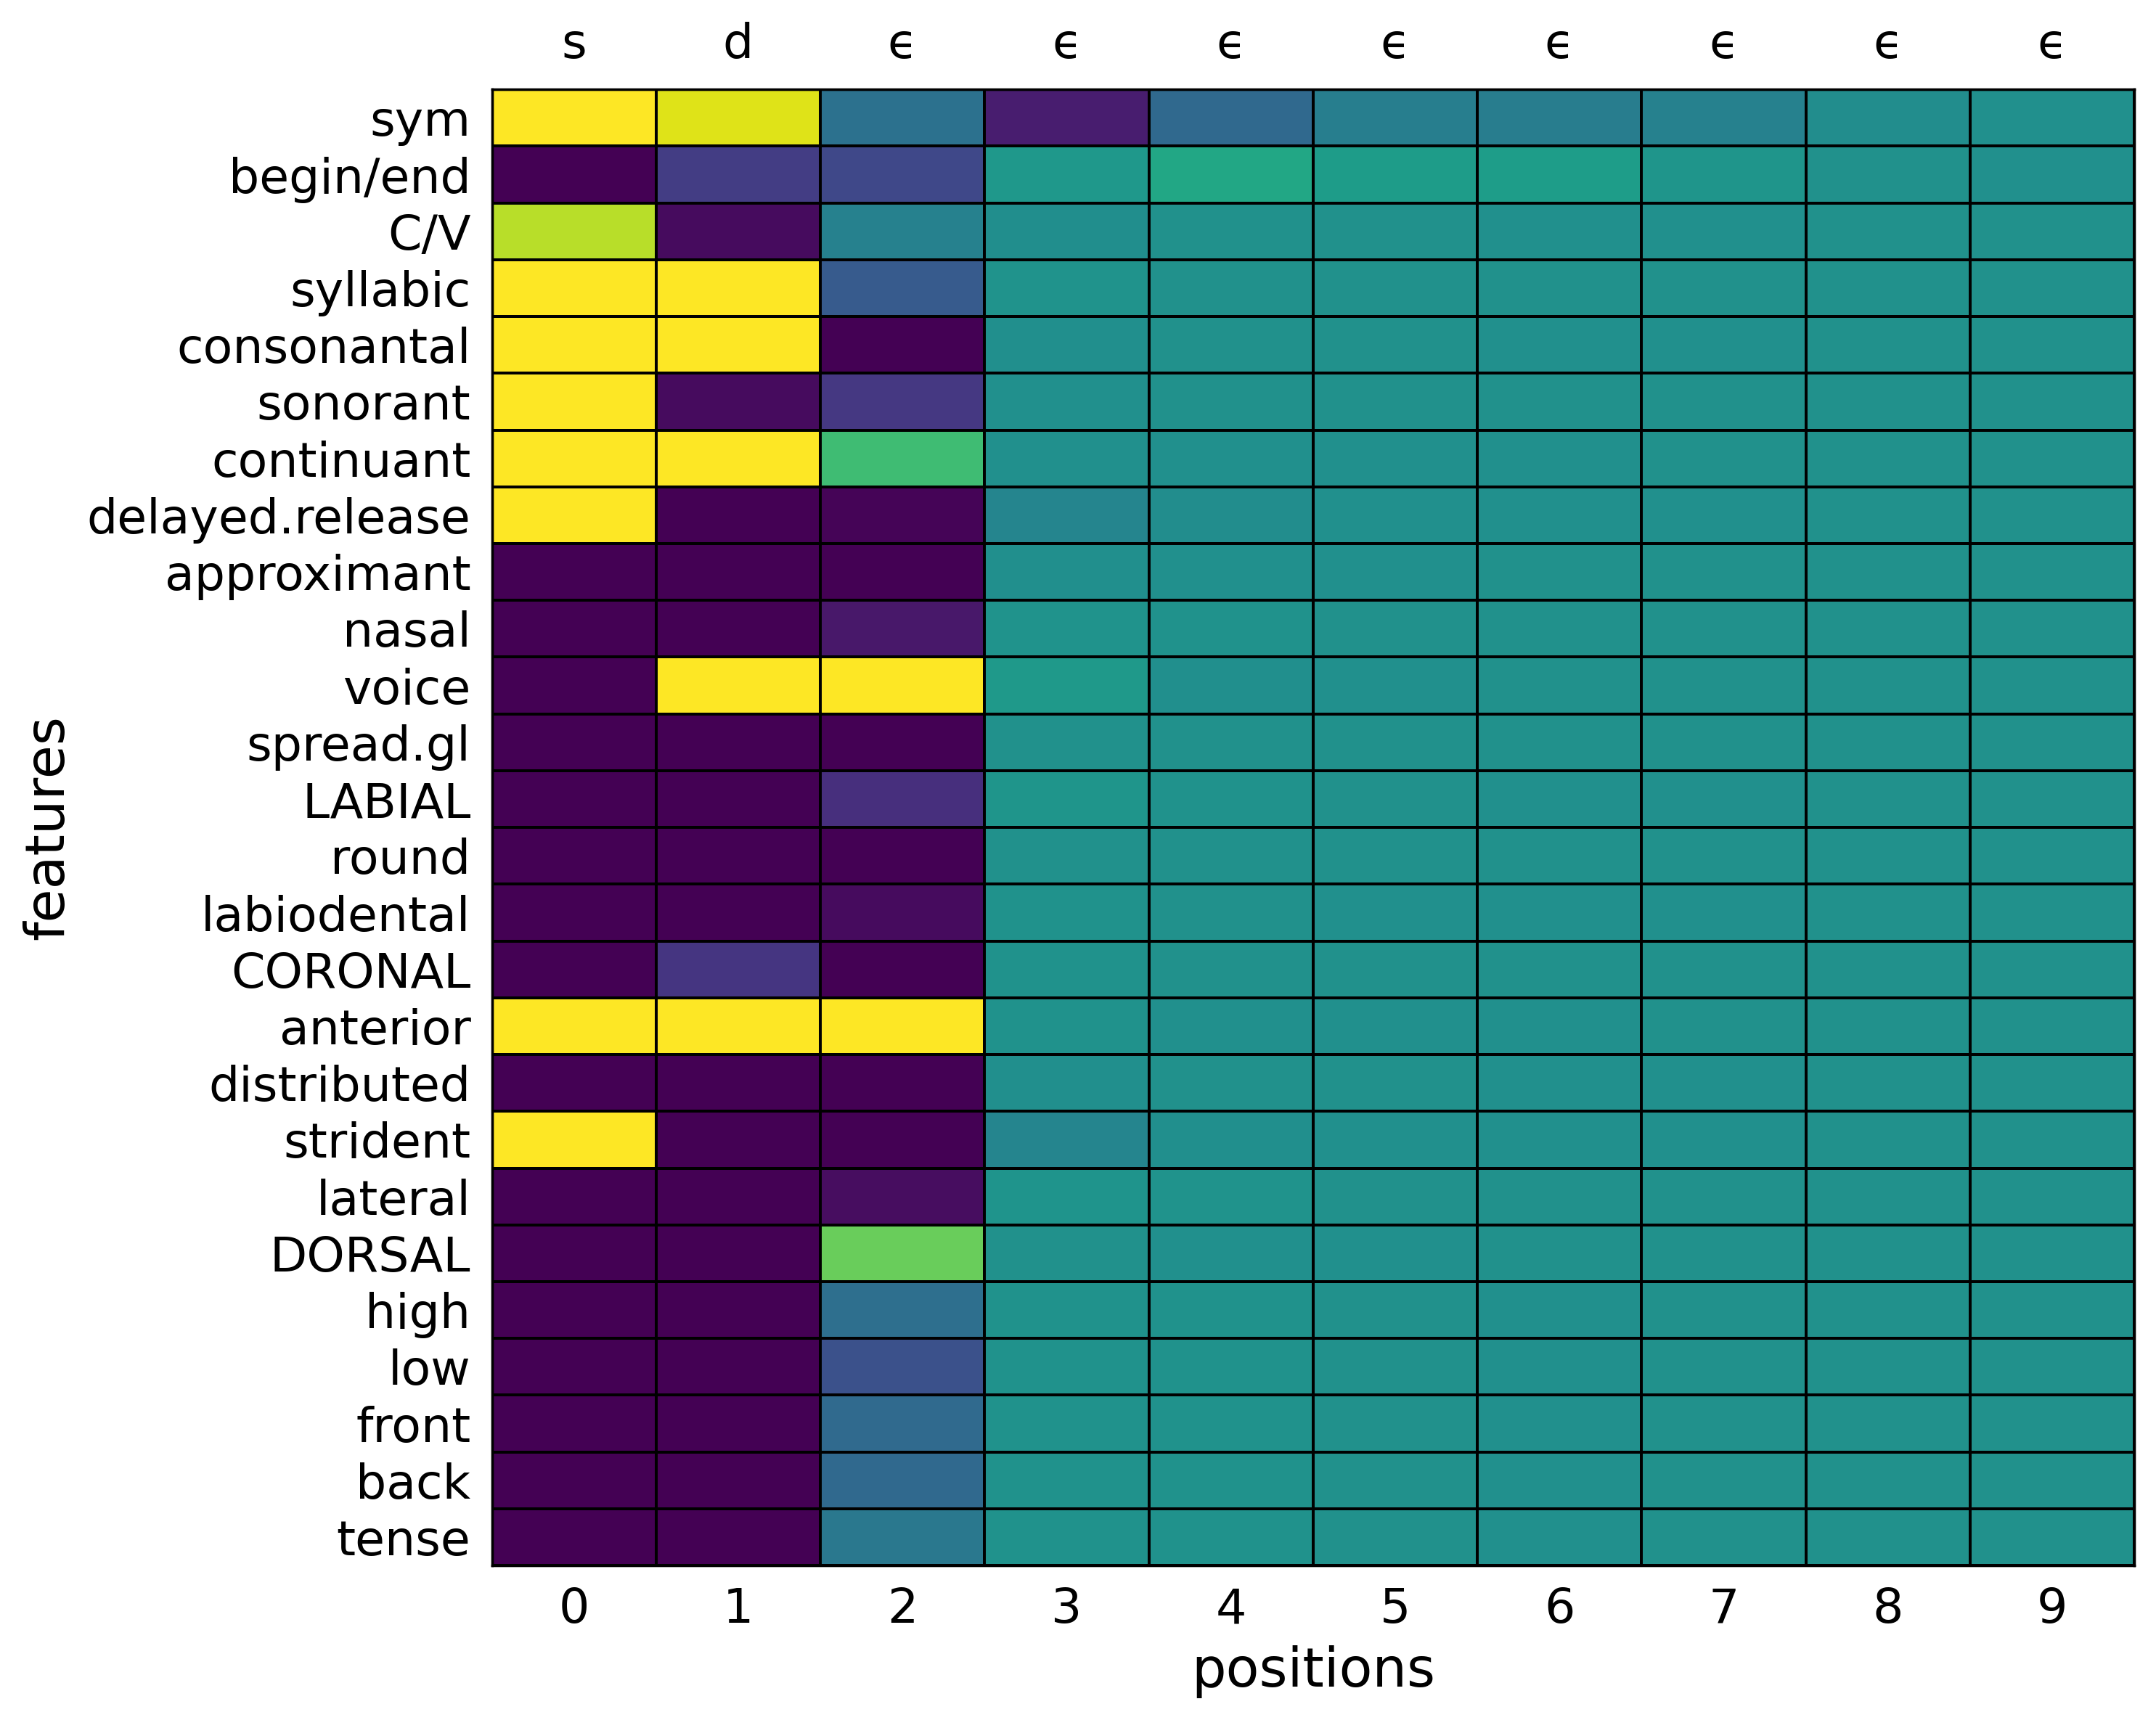

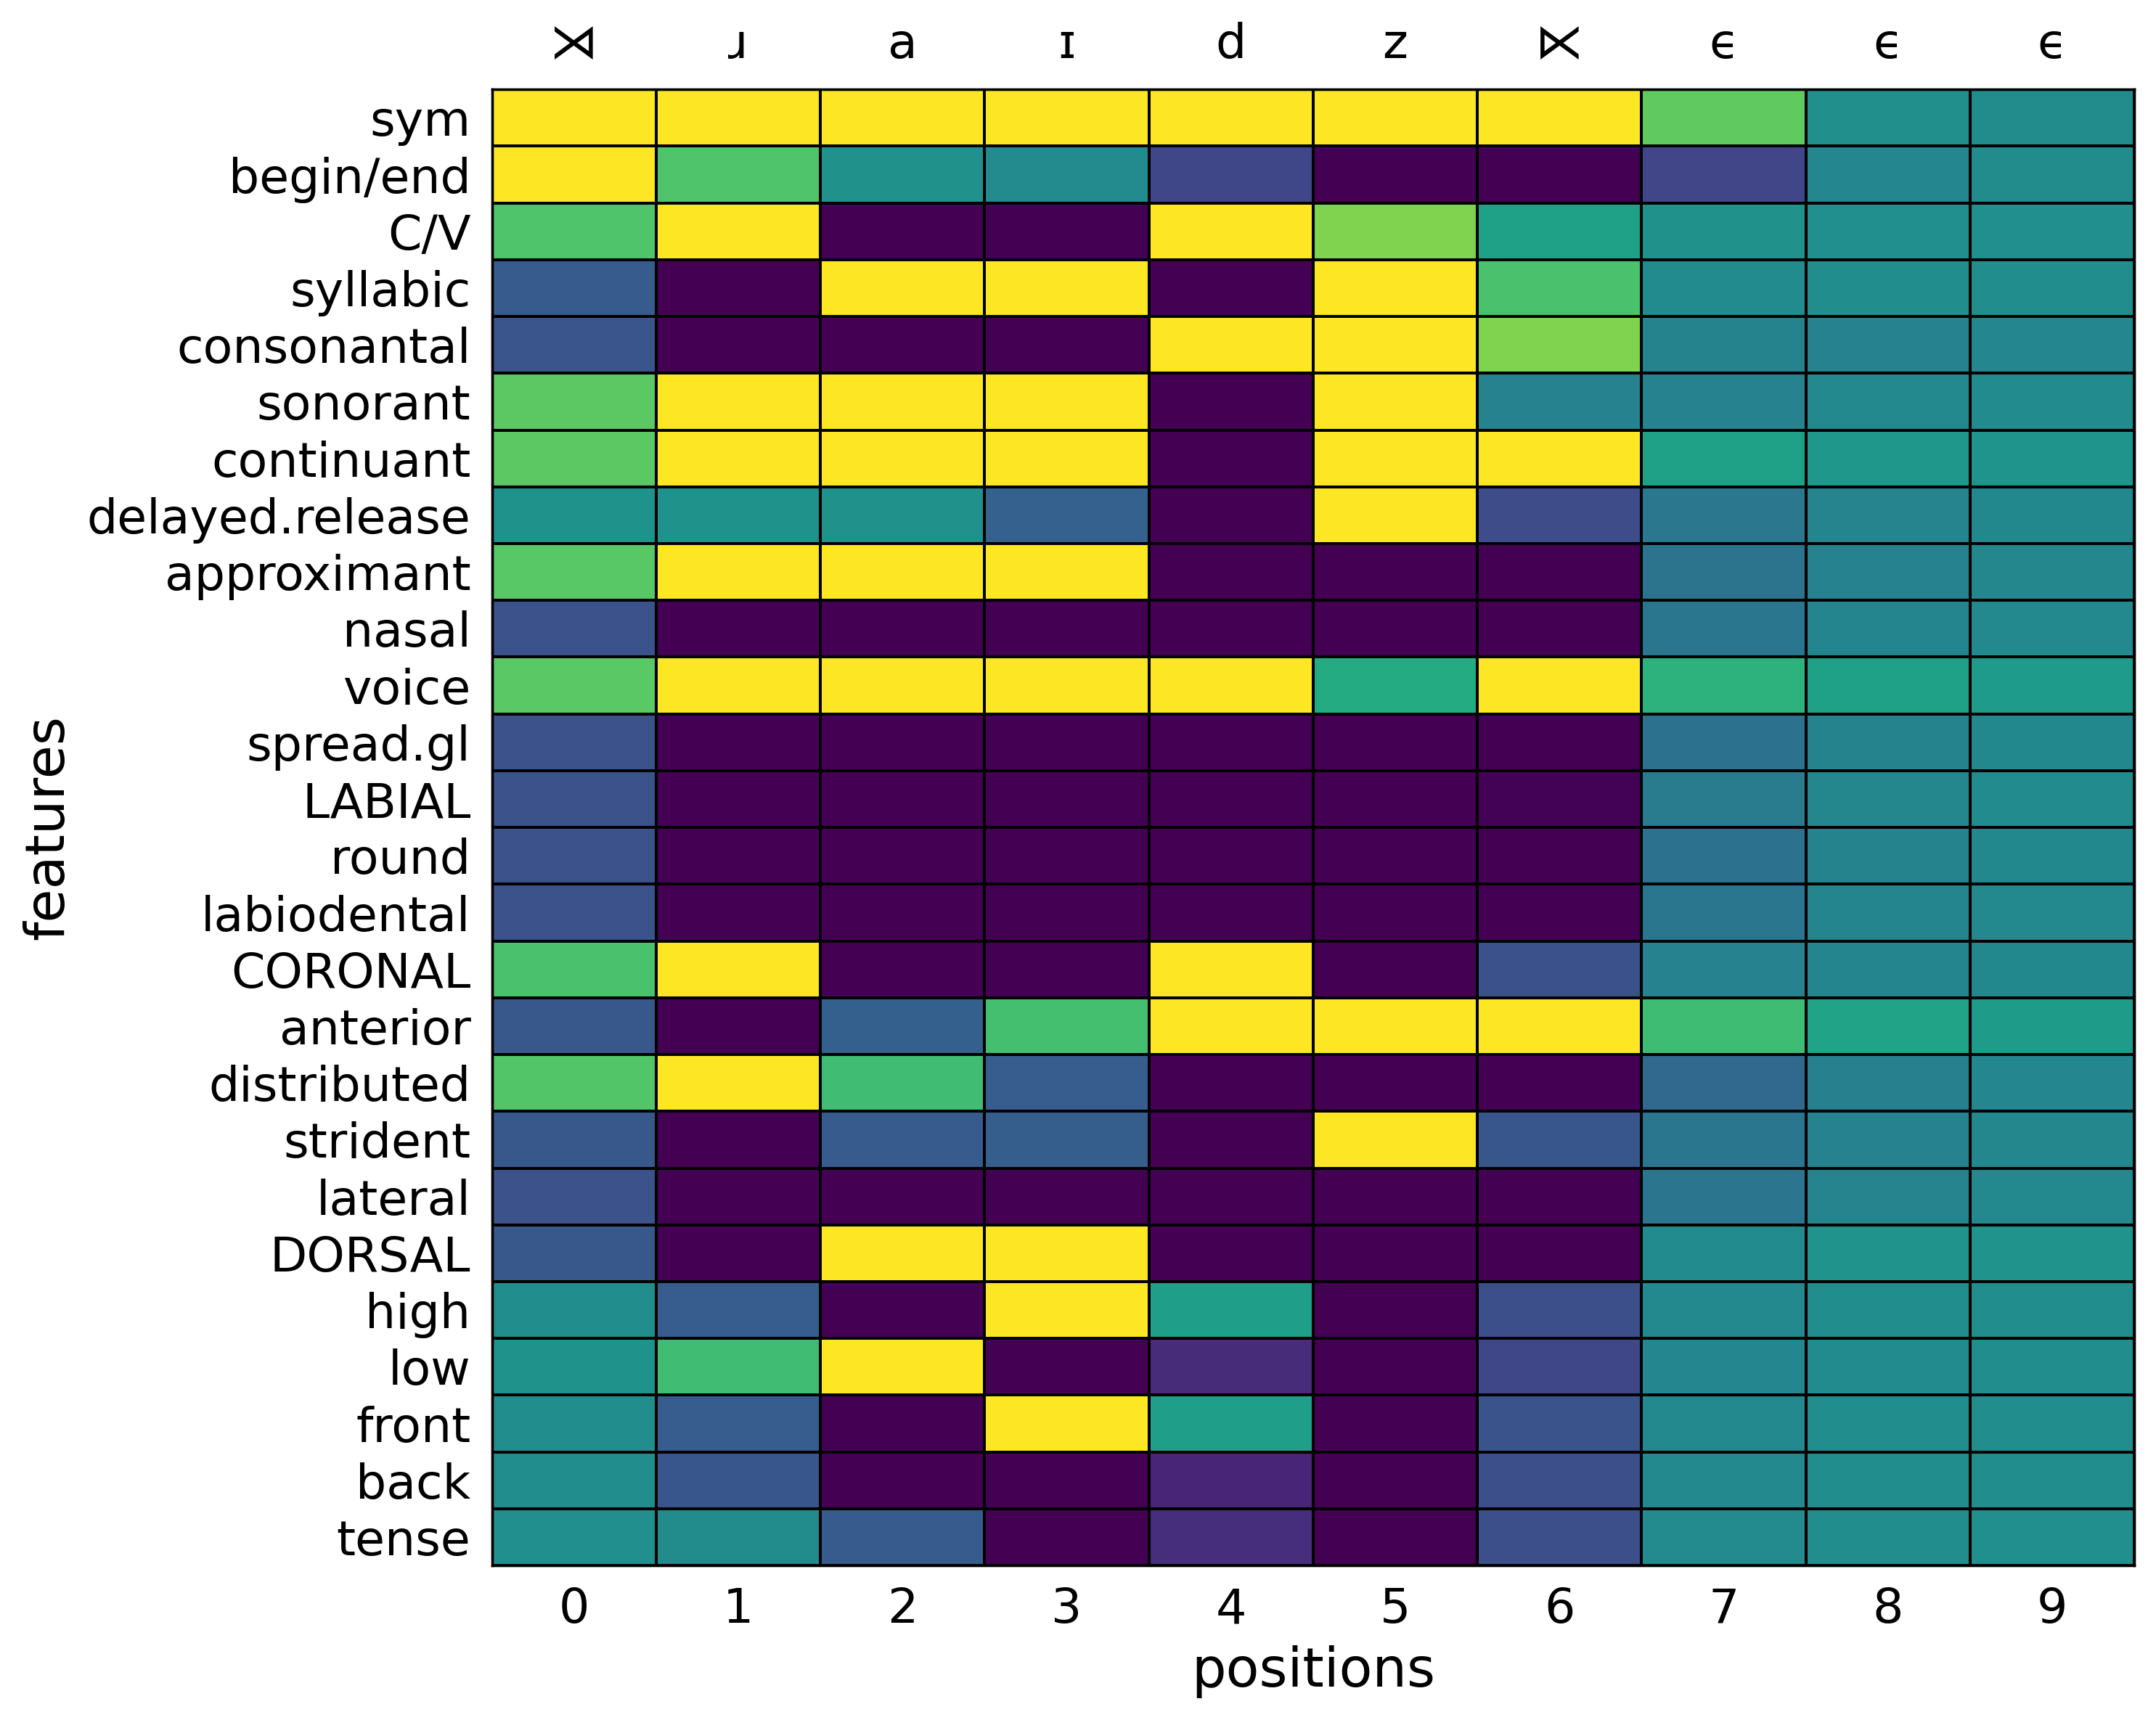

In [20]:
stem_ = stem._str(markup=False)[0]
plot_tpr(stem.form[0], stem_, nrole=10)

affix_ = affix._str(markup=False)[0]
plot_tpr(affix.form[0], affix_, nrole=10)

outpt_ = outpt._str(markup=False)[0]
plot_tpr(outpt.form[0], outpt_, nrole=10)

In [13]:
# Phonological constraints
print(phonology)
cntxt = torch.ones(1)
print('Faithfulness constraints')
print('w_nochng', torch.exp(phonology.w_nochng(cntxt)) + phonology.w_faith)
print('w_nodeln', torch.exp(phonology.w_nodeln(cntxt)) + phonology.w_faith)
print('w_noepen', torch.exp(phonology.w_noepen(cntxt)) + phonology.w_faith)
print()

Phonology(
  (matcher): Matcher3(
    (matcher_prev): LiteralMatcher(
      (W): Linear(in_features=1, out_features=520, bias=True)
    )
    (matcher_cntr): LiteralMatcher(
      (W): Linear(in_features=1, out_features=520, bias=True)
    )
    (matcher_next): LiteralMatcher(
      (W): Linear(in_features=1, out_features=520, bias=True)
    )
  )
  (mod): Linear(in_features=1, out_features=120, bias=True)
  (w_chng): Linear(in_features=1, out_features=520, bias=True)
  (w_deln): Linear(in_features=1, out_features=20, bias=True)
  (w_epen): Linear(in_features=1, out_features=80, bias=True)
  (v_chng): Linear(in_features=1, out_features=520, bias=True)
  (v_epen): Linear(in_features=1, out_features=2080, bias=True)
  (w_nochng): Linear(in_features=1, out_features=26, bias=True)
  (w_nodeln): Linear(in_features=1, out_features=1, bias=True)
  (w_noepen): Linear(in_features=1, out_features=1, bias=True)
)
Faithfulness constraints
w_nochng tensor([1.7958, 4.5698, 0.4333, 1.3609, 0.2157, 1.

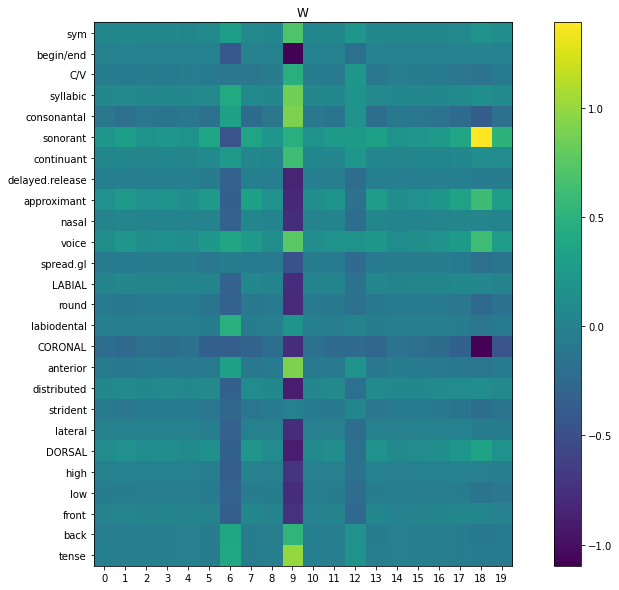

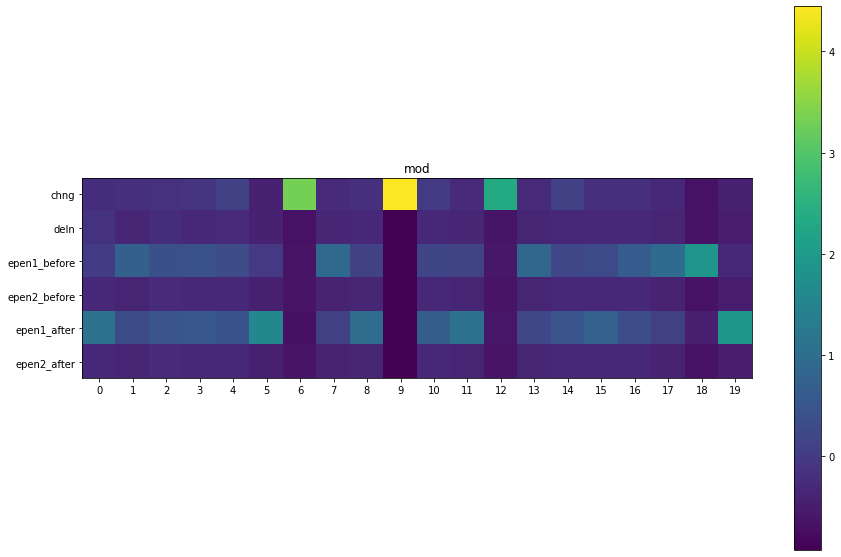

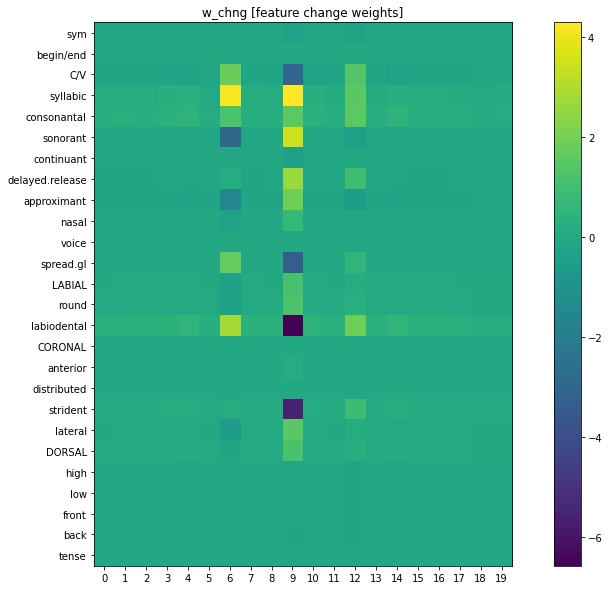

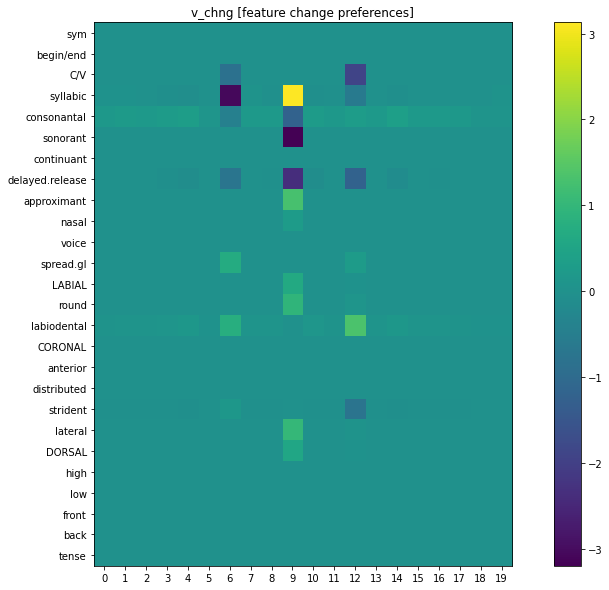

In [14]:
# Phonological constraints
npattern = phonology.npattern

## Match weights
W = phonology.matcher.matcher_next.trace['W'][0,:,:,0]
#Wpos = phonology.matcher.matcher_next.trace['Wpos'][0,:,:,0]
#Wneg = phonology.matcher.matcher_next.trace['Wneg'][0,:,:,0]

imshow(W.t(), xlab=range(npattern), ylab=config.ftrs, title='W')

## Preferred modifications
mod_types = phonology.mod_types
mod = phonology.trace['mod'][0]
#mod = torch.softmax(mod, -1)
imshow(mod.t(), xlab=range(npattern), ylab=mod_types, title='mod')

## Change weights
w_chng = phonology.trace['w_chng'][0]
imshow(w_chng.t(), xlab=range(npattern), ylab=config.ftrs, title='w_chng [feature change weights]')

## Change preferences
v_chng = phonology.trace['v_chng'][0]
imshow(v_chng.t(), xlab=range(npattern), ylab=config.ftrs, title='v_chng [feature change preferences]')

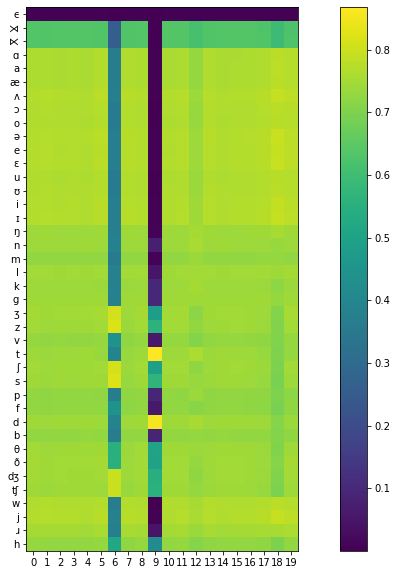

In [16]:
# Phonological constraints - matching
cntxt = torch.ones(1)
match = phonology.matcher.matcher_prev(3.0 * config.F.unsqueeze(0), cntxt)
match = torch.exp(match)
#print(len(config.ftrs), len(config.syms))
#print(config.F.shape)
imshow(match[0].t(), xlab=range(npattern), ylab=config.syms)
#print(match_prev.shape)

#_ = plt.plot(match[0].t().data.numpy())

torch.Size([1, 40, 22])
tensor([ -38.3488,  -38.3680,  -38.5900,  -41.0140,  -30.2751,  -24.9390,
         -33.1248,  -54.3803,  -64.4018,  -22.3860,  -27.0713,  -17.0498,
         -58.5218,  -48.5003,  -21.1914,  -11.1698,  -62.6807,  -89.2037,
         -82.5877,  -69.0134,  -75.4641,  -64.4832,  -83.9695,  -82.4675,
         -69.6772, -101.9871,  -94.9505,  -93.4484,  -95.3710,  -80.6581,
         -91.0061,  -84.3901,  -92.8480,  -81.8671,  -94.8599, -105.8408,
         -72.8909,  -35.5604,  -58.3218,  -80.5483], grad_fn=<SelectBackward>)
tensor(-2.4448, grad_fn=<MaxBackward1>)
tensor(-14.7748, grad_fn=<MaxBackward1>)
tensor(-14.7552, grad_fn=<MaxBackward1>)
tensor(-11.1698, grad_fn=<MaxBackward1>)
tensor(-29.7622, grad_fn=<MaxBackward1>)
tensor(-43.0363, grad_fn=<MaxBackward1>)
tensor(-47.0776, grad_fn=<MaxBackward1>)
tensor(-32.8075, grad_fn=<MaxBackward1>)
tensor(-23.9658, grad_fn=<MaxBackward1>)
tensor(-17.3856, grad_fn=<MaxBackward1>)
⋊ ɹ a ɪ z ə z 
['⋊ ɹ a ɪ z ə ⋉ ⋉ ϵ ϵ ϵ ϵ ϵ ϵ

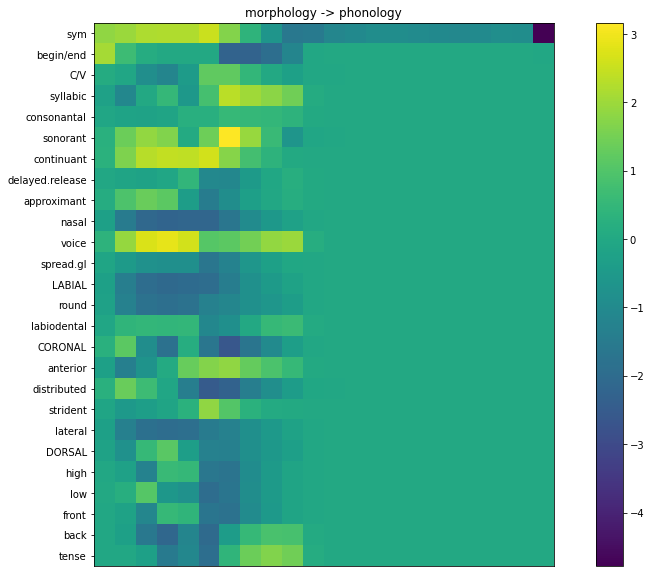

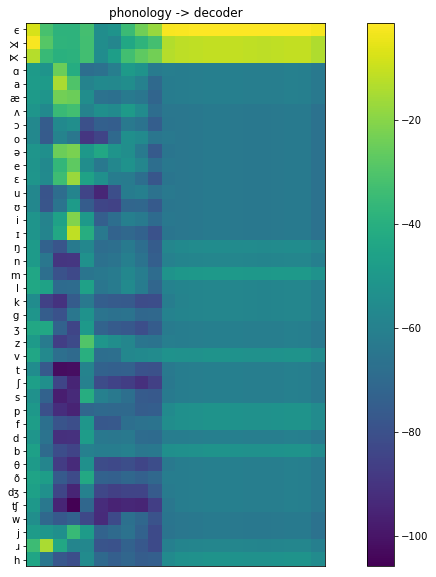

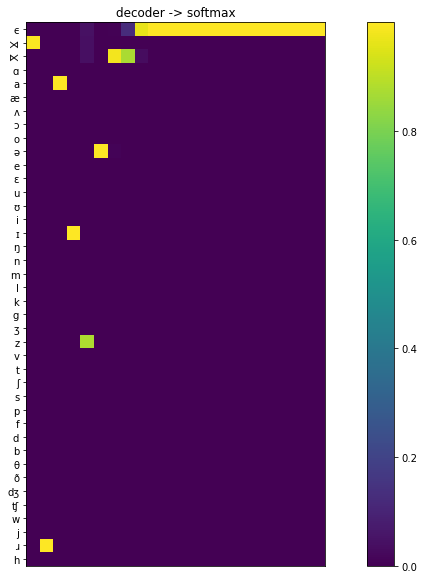

In [17]:
# Morphological output -> phonological output
cntxt = torch.ones(1)
outpt2 = morph.Morph(phonology(outpt.form, cntxt))
#outpt2.form = 0.25 * outpt.form + 0.75 * outpt2.form
outpt3 = decoder(outpt2.form)
outpt4 = torch.softmax(outpt3, dim=1)

print(outpt3.shape)
print(outpt3[0,:,3])
for i in range(10):
    print(torch.max(outpt3[0,:,i]))

imshow(outpt2.form[0], xlab=[], ylab=config.ftrs, title='morphology -> phonology')

imshow(outpt3[0], xlab=[], ylab=config.syms, title='phonology -> decoder')

imshow(outpt4[0], xlab=[], ylab=config.syms, title='decoder -> softmax')

outpt2_ = form_embedder.tpr2string(outpt2.form)
print(outpt_)
print(outpt2_)

In [20]:
# Morphological output -> phonological output at critical input position(s)
cntxt = torch.ones(1)
outpt2 = morph.Morph(phonology(outpt.form, cntxt, input_posns = [6]))
#outpt2.form = 0.25 * outpt.form + 0.75 * outpt2.form
outpt3 = decoder(outpt2.form)
outpt4 = torch.softmax(outpt3, dim=1)

outpt2_ = form_embedder.tpr2string(outpt2.form)
print(outpt2_)

['⋉ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ']


torch.Size([1, 20, 22])


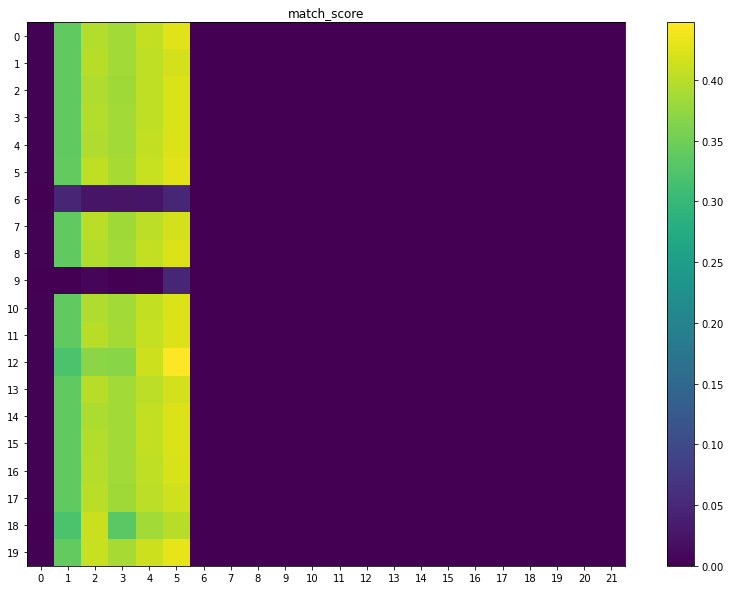

In [21]:
# Match of phonological constraint contexts
match_score = phonology.matcher(outpt.form, cntxt)
match_score = torch.exp(match_score)
print(match_score.shape)

imshow(match_score[0], xlab=range(config.nrole), ylab=range(npattern), title='match_score')

⋊ ɹ a ɪ z ə z 
⋊ ɹ a ɪ z ə ⋉


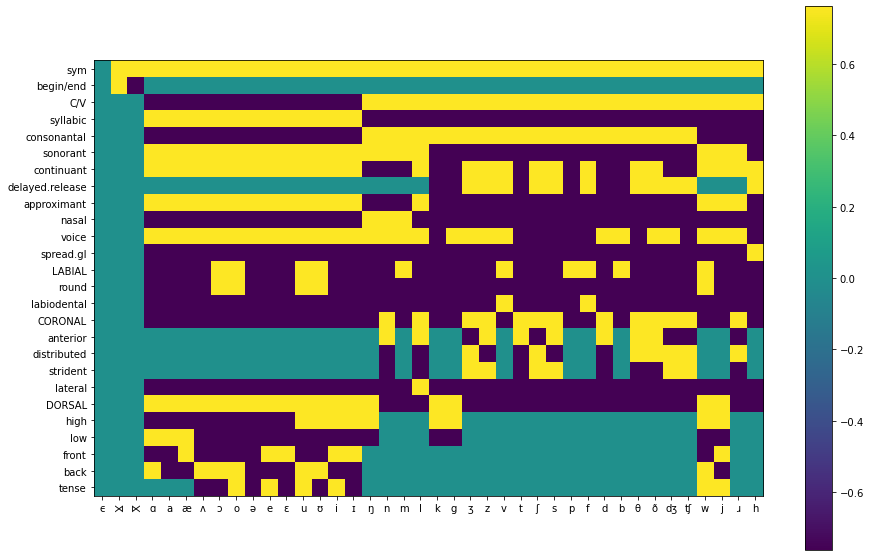

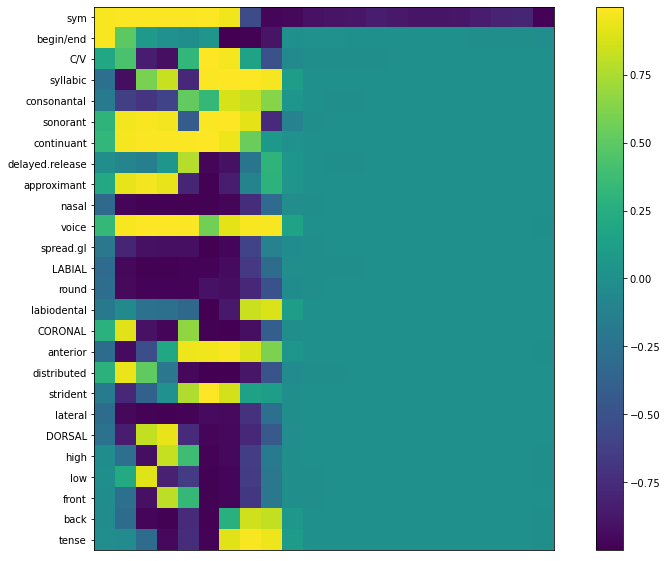

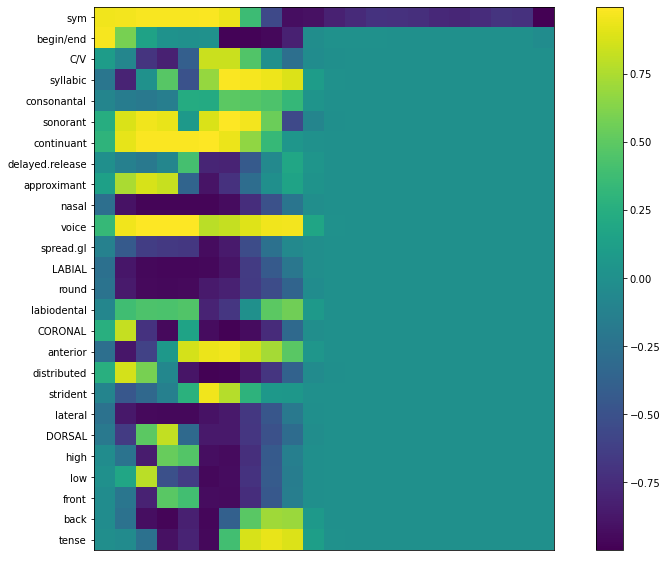

In [22]:
cntxt = torch.ones(1,1)
outpt_fake = morph.Morph(form_embedder.string2tpr('⋊ ɹ ɪ s k ə ⋉').unsqueeze(0))
phon_outpt = phonology(outpt.form, cntxt)
print(outpt._str()[0])
print(morph.Morph(phon_outpt)._str()[0])

imshow(torch.tanh(config.F), xlab=config.syms, ylab=config.ftrs, title='')

imshow(torch.tanh(outpt.form)[0], xlab=[], ylab=config.ftrs, title='')

imshow(torch.tanh(phon_outpt)[0], xlab=[], ylab=config.ftrs, title='')


['ϵ', '⋊', '⋉', 'ɑ', 'a', 'æ', 'ʌ', 'ɔ', 'o', 'ə', 'e', 'ɛ', 'u', 'ʊ', 'i', 'ɪ', 'ŋ', 'n', 'm', 'l', 'k', 'g', 'ʒ', 'z', 'v', 't', 'ʃ', 's', 'p', 'f', 'd', 'b', 'θ', 'ð', 'dʒ', 'tʃ', 'w', 'j', 'ɹ', 'h']
ə -> ə / f __ ϵ


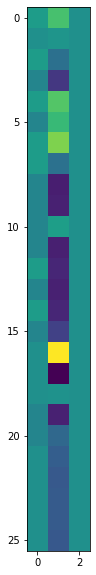

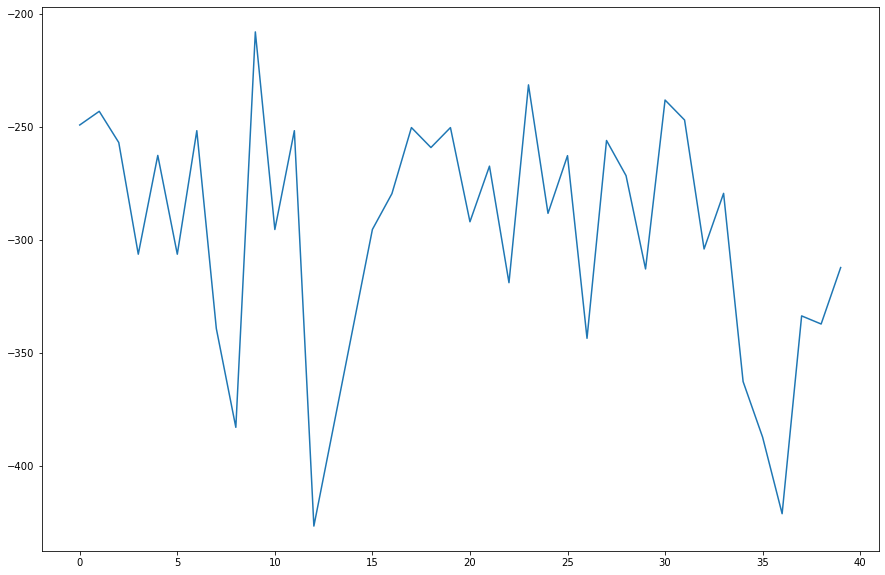

In [13]:
# Equivalent ISL transducer (with one-segment look-ahead and look-behind)
syms = config.syms[:]
# Windows of three input segments
# xxx batch
print(config.syms)
mapping = []
for c in ['f']: #syms:
    for a in ['ə']: #syms:
        for d in ['ϵ']: #syms:
            c_indx = form_embedder.sym2id[c]
            a_indx = form_embedder.sym2id[a]
            d_indx = form_embedder.sym2id[d]
            inpt = torch.stack([config.F[:,c_indx], affix.form[0][:,1], config.F[:,d_indx]], 1)
            inpt = inpt.unsqueeze(0)
            cntxt = torch.ones(1)
            outpt = phonology(inpt, cntxt, input_posns=[1])
            outpt_ = form_embedder.tpr2string(outpt)[0]
            outpt_ = re.sub(config.epsilon, '', outpt_).strip()
            # Non-identity maps
            if outpt_ != a or 1:
                print(f'{a} -> {outpt_} / {c} __ {d}')
            mapping.append((a, outpt_, c, d))

outpt3 = decoder(outpt)
outpt4 = torch.softmax(outpt3, dim=1)

fig, ax = plt.subplots(1,1)
ax.imshow(inpt.detach().numpy()[0])

fig, ax = plt.subplots(1,1)
ax.plot(outpt3.detach().numpy()[0,:,0])
#ax.imshow(outpt.detach().numpy()[0])

In [14]:
# Equivalent transducer (morphology + phonology)
#grammar.cogrammar.phonology = phonology
syms = config.syms[:]
syms.remove(config.epsilon)
syms.remove(config.bos)
syms.remove(config.eos)
# Windows of three input segments
# xxx batch
mapping = []
for c in ['b b ˈɛ']: #syms:
    for a in syms:
        inpt_ = ' '.join([config.bos, c, a, 'ə', config.eos])
        inpt = form_embedder.string2tpr(inpt_, delim=False)
        cntxt = torch.ones(1,2)
        batch = {'stem':morph.Morph(inpt.unsqueeze(0)), 'morphosyn':[cntxt], 'max_len':15}
        outpt = grammar(batch)
        outpt_ = outpt._str()[0]
        #outpt_ = form_embedder.tpr2string(outpt.form)[0]
        #outpt_ = re.sub(config.epsilon, '', outpt_).strip()
        mapping.append((inpt_, outpt_))
    break

print(mapping)

string2idvec error: ⋊ b b ˈɛ ɑ ə ⋉
[('⋊', 1), ('b', 31), ('b', 31), ('ˈɛ', None), ('ɑ', 3), ('ə', 9), ('⋉', 2)]


SystemExit: 0

/Library/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
